# Dali Data Challenge
## Joshua Pfefferkorn

In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau

# Data Loading

In [10]:
# load in sales data as a pandas dataframe
sales_data = pd.read_csv('Sample - Superstore.csv', encoding='windows-1252')
# preview data
sales_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [11]:
# view columns and data types, check for missing values
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

# Visualizations

Let's examine sales vs. profit separated by a few different measures.

## Sales vs. Profit by Segment:

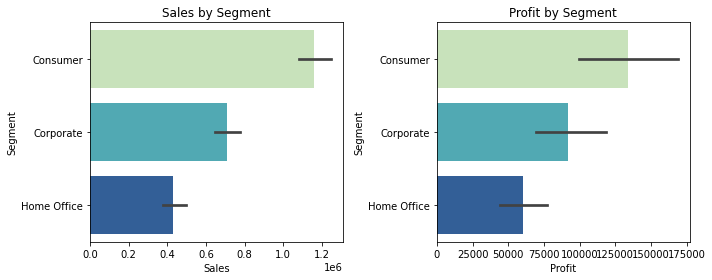

In [22]:
# set up viewing properties
plt.rcParams["figure.figsize"] = [10, 4]
fig, axes = plt.subplots(1, 2)

# plot data
sns.barplot(x='Sales', y='Segment',data=sales_data, palette='YlGnBu',
            estimator=sum, ax=axes[0]).set_title('Sales by Segment')
sns.barplot(x='Profit', y='Segment',data=sales_data, palette='YlGnBu',
            estimator=sum, ax=axes[1]).set_title('Profit by Segment')

fig.tight_layout()
plt.show()

## Sales vs. Profit by Sub-Category:

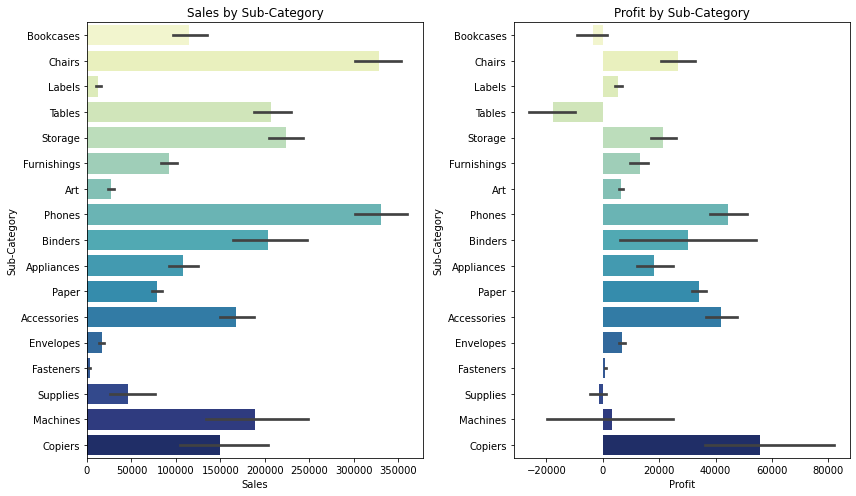

In [26]:
# set up viewing properties
plt.rcParams["figure.figsize"] = [12, 7]

# plot data
fig, axes = plt.subplots(1, 2)
sns.barplot(x='Sales', y='Sub-Category',data=sales_data, palette='YlGnBu',
            estimator=sum, ax=axes[0]).set_title('Sales by Sub-Category')
sns.barplot(x='Profit', y='Sub-Category',data=sales_data, palette='YlGnBu',
            estimator=sum, ax=axes[1]).set_title('Profit by Sub-Category')

fig.tight_layout()
plt.show()

## Sales vs. Profit by State:

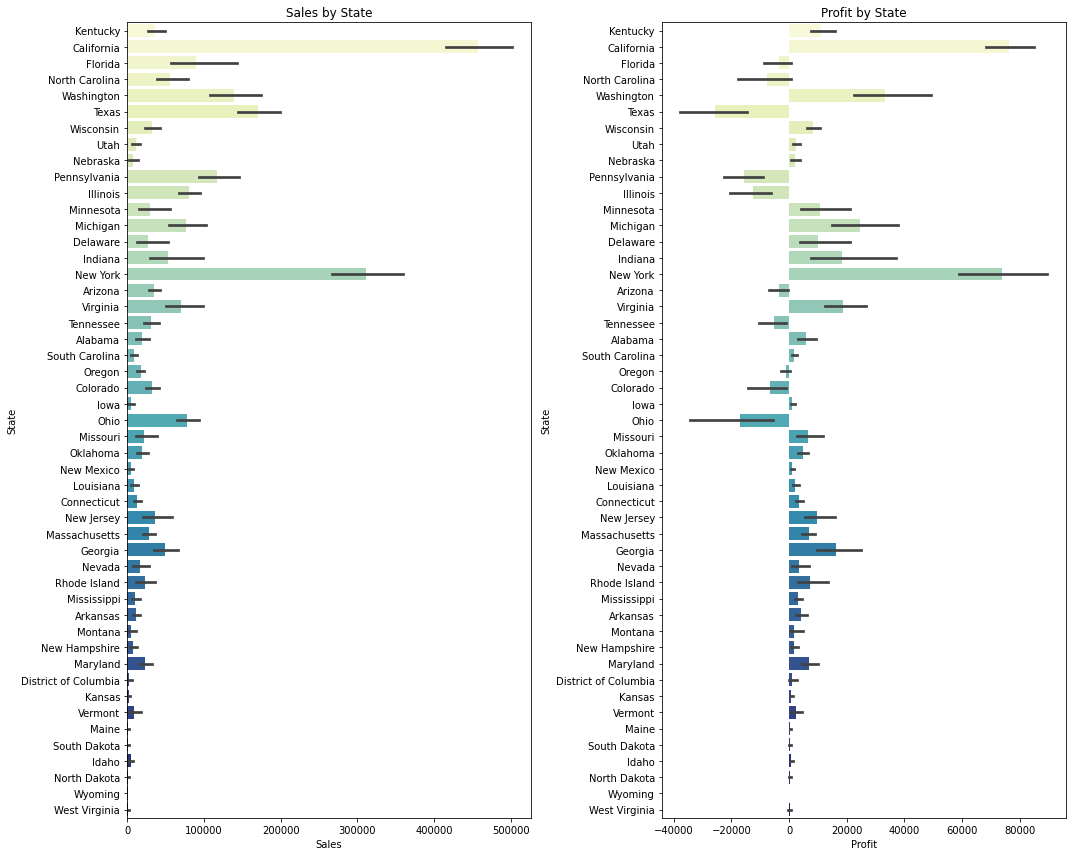

In [27]:
# set up viewing properties
plt.rcParams["figure.figsize"] = [15, 12]
fig, axes = plt.subplots(1, 2)

# plot data
sns.barplot(x='Sales', y='State',data=sales_data, palette='YlGnBu',
            estimator=sum, ax=axes[0]).set_title('Sales by State')
sns.barplot(x='Profit', y='State',data=sales_data, palette='YlGnBu',
            estimator=sum, ax=axes[1]).set_title('Profit by State')

fig.tight_layout()
plt.show()

Now, let's look at relatedness between features.

## Feature correlations:

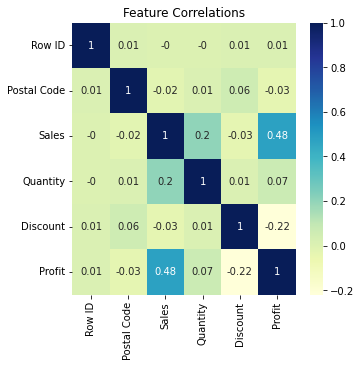

In [28]:
# create correlation map
correlation = sales_data.corr().round(2)

# plot via a heatmap
plt.rcParams["figure.figsize"] = [5, 5]
sns.heatmap(data=correlation, annot=True, cmap='YlGnBu').set_title("Feature Correlations")
plt.yticks(rotation=0) 
plt.show()

We notice a positive correlation between sales and profit (as expected), and a negative correlation between discount and profit. We can examine this further using a scatter plot.

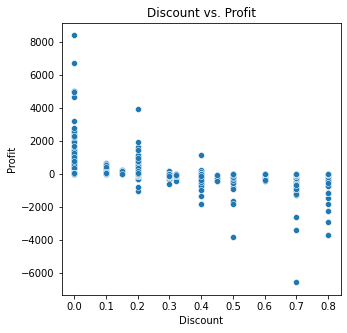

In [29]:
sns.scatterplot(x='Discount', y='Profit',data=sales_data, palette='YlGnBu').set_title('Discount vs. Profit')
plt.show()

We notices that profits tend to dip negative at around 20% discount.

# Data Preprocessing

In [234]:
# drop uninformative columns
sales_data = sales_data.drop(columns=['Row ID','Order ID','Customer ID', 'Customer Name','Country'])

In [235]:
# convert dates to more uesful values
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])
sales_data['Ship Date'] = pd.to_datetime(sales_data['Ship Date'])

# replaces a date column with three new columns representing year, month, and day
def expand_dates(df, cols):
    df = df.copy()
    
    # add new columns for day, month, and year
    for i in range(len(cols)):
        df[cols[i] + ' (Day)'] = df[cols[i]].apply(lambda date: date.day)
        df[cols[i] + ' (Month)'] = df[cols[i]].apply(lambda date: date.month)
        df[cols[i] + ' (Year)'] = df[cols[i]].apply(lambda date: date.year)
    
    # drop old date column
    df = df.drop(columns=cols)
    return df
    
sales_data = expand_dates(sales_data, ['Order Date', 'Ship Date'])

In [236]:
# one hot encodes columns with categorical data
def one_hot_encode(df, cols):
    df = df.copy()
    
    # add columns for each feature label in the column
    for i in range(len(cols)):
        one_hot = pd.get_dummies(df[cols[i]], prefix=cols[i])
        df = pd.concat([df, one_hot], axis=1)
    
    # drop the categorical columns
    df = df.drop(columns=cols)
    return df

sales_data = one_hot_encode(sales_data, ['Ship Mode',
                                         'Segment', 
                                         'City',
                                         'State', 
                                         'Postal Code', 
                                         'Region', 
                                         'Product ID', 
                                         'Category', 
                                         'Sub-Category',
                                         'Product Name'])


In [237]:
# add a column for the target metric
sales_data['Profit Margin Ratio'] = sales_data['Profit'] / sales_data['Sales']

# we no longer need the sales and profit columns
sales_data = sales_data.drop(columns=['Profit', 'Sales'])

# Predicting Profit Margin Ratio

In [238]:
# set x (features) and y (target)
y = sales_data['Profit Margin Ratio'].values
x = sales_data.drop(columns=['Profit Margin Ratio']).values

# split the data into 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True)

In [239]:
# create a sequential model
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

In [243]:
# train the model on the data
model.compile(
    optimizer='adam',
    loss='mse'
)

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        ReduceLROnPlateau()
    ]
)

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 12.1401 - val_loss: 0.1038 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0882 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0692 - lr: 0.0010
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0620 - lr: 0.0010
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0738 - lr: 0.0010
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0643 - lr: 0.0010
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0759 - lr: 0.0010
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0620 - lr: 0.0010
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0595 - val

In [244]:
# compute loss (MSE)
test_loss = model.evaluate(x_test, y_test, verbose=0)
print("Loss:", test_loss)

Loss: 0.02354072593152523


In [245]:
# compute R2 score
y_pred = np.squeeze(model.predict(x_test))
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

R2 Score: 0.8939685082645799
